<div class="cite2c-biblio"></div>

# Get US Data From FRED


In [1]:
## Using Jupter and Spyder\Atom Together
## https://medium.com/@rrfd/cookiecutter-data-science-organize-your-projects-atom-and-jupyter-2be7862f487e
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# my functions and oter iports
import src.config as config
from src.config import my_pd as pd
from src.config import my_plt as plt
file_date = config.file_date
from src.funct.ncDate import period
from src.funct.ncPlot import multi_save, add_Rec, plot1ax, plot2axs, colors
from src.funct import ncStat

# very importent - get Project Main Path
project_path = config.project_path
current_NB_path = 'src/data/'
import os
os.chdir(project_path)

import numpy as np
import statsmodels as st
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
# set plot parameters
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')

## Data from FRED

In [4]:
import src.data.read_from_Fred as fred

In [5]:
Get_New_Data_from_FRED = False
if Get_New_Data_from_FRED:
    fred.Get_from_FRED()
df_US   = fred.Get_data()
df_info = fred.Get_info()
#df_info

## Intrest Rates

In [6]:
df_US['CC_IR']=df_US['TERMCBCCINTNS']
df_info.at['title','CC_IR']='CreditCard_Intrest Rate'
df_US['CC_IR'].interpolate(inplace=True)

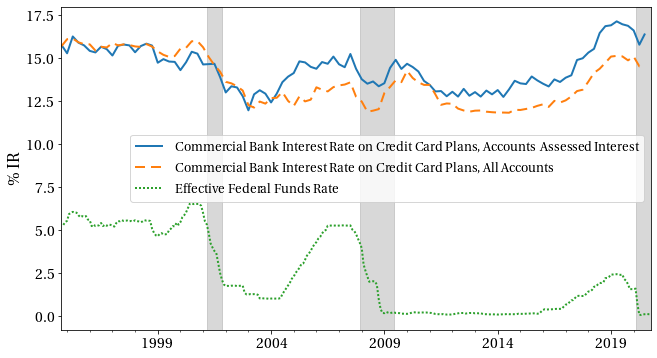

In [7]:
IR_col = ['TERMCBCCINTNS', 'TERMCBCCALLNS', 'FEDFUNDS']
mask = period(df_US.index,start=df_info.at['observation_start','TERMCBCCINTNS'])
ax = plot1ax(columns=IR_col,labels=list(df_info.loc['title',IR_col]),
             df=df_US.loc[mask,IR_col],markers='',
             ylabel='\% IR') # bbox=(1, -0.12)
add_Rec(ax,df_US,'USRECM');

Calculate additional varibels

In [8]:
# Calculate Spreads and Leverege
df_US['FED_q'] = df_US['FEDFUNDS'].rolling(window=3,center=True).mean()
df_US['spread CC Accounts Assessed'] = df_US['TERMCBCCINTNS'] - df_US['FEDFUNDS']
df_US['spread CC all']               = df_US['TERMCBCCALLNS'] - df_US['FEDFUNDS']
df_US['CC_spread'] = df_US['CC_IR'] - df_US['FEDFUNDS']

df_US['proxGDP'] = df_US['PCE'] +df_US['GPDI']
df_US['Debt Over proxGDP'] = df_US['CMDEBT']/df_US['proxGDP']
df_US['Debt Over GDP'] = df_US['CMDEBT']/df_US['GDP']

Get borrowers IR as in BER Paper

In [9]:
mask_till2009 = period(df_US.index,start='1995-02-01',end='2009-02-01')
mean_till2009 = df_US[mask_till2009].mean()
df_US['BER borrowers IR'] = df_US['CC_spread'] \
                            - mean_till2009['CC_spread'] \
                            + df_US['FED_q']

save as processed data

In [10]:
path = 'data/processed/' 
df_US.to_csv(path+'fromFRED_data.csv')

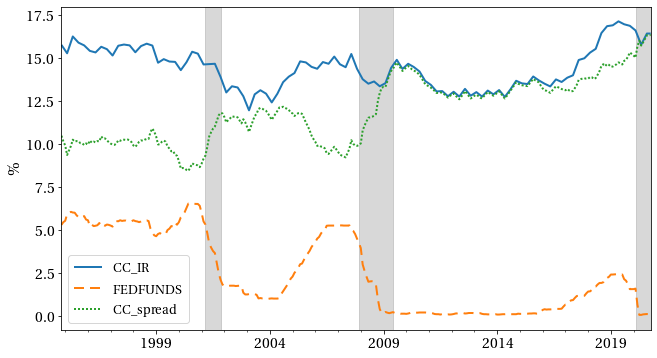

In [11]:
mask = period(df_US.index,start=df_info.at['observation_start','TERMCBCCINTNS'])
plot_col = ['CC_IR','FEDFUNDS', 'CC_spread']
#with plt.xkcd():
if True:
    ax = plot1ax(columns=plot_col,df=df_US.loc[mask,plot_col],
                 markers='',ylabel='\%')
    add_Rec(ax,df_US,'USRECM');

## Leverage

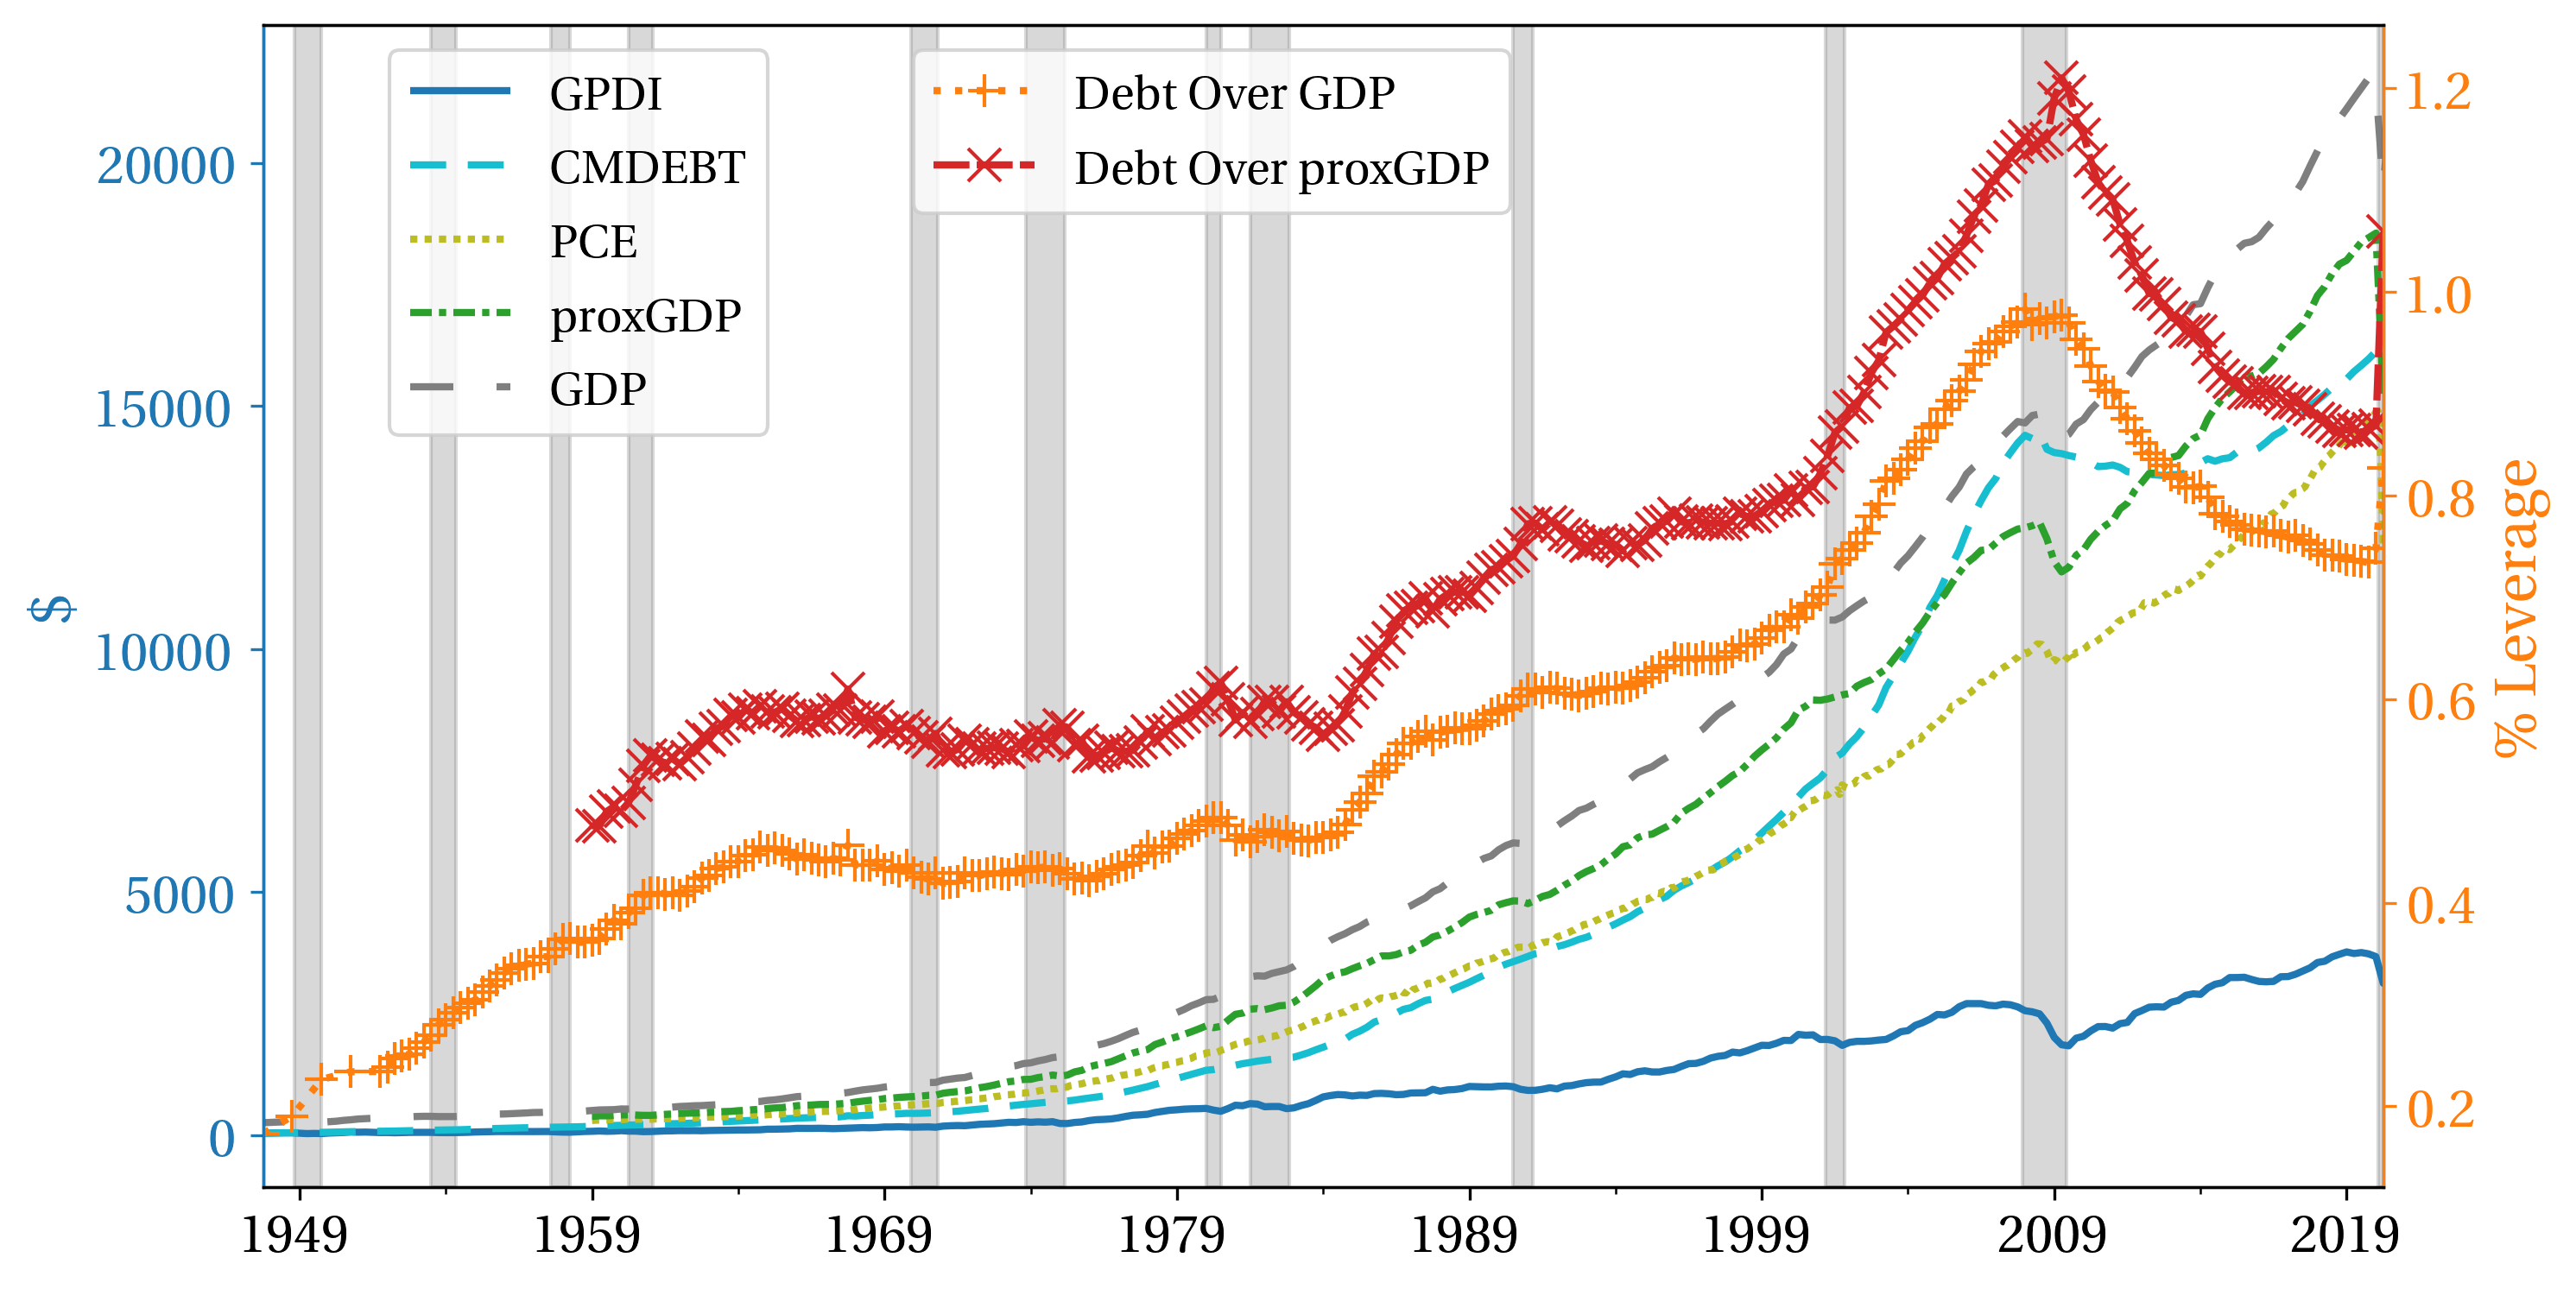

In [55]:
mask = period(df_US.index,start=df_info.at['observation_start','CMDEBT'])#start = '2015-02-01'
#with plt.xkcd():
if True:
    columns1 = ['GPDI', 'CMDEBT', 'PCE','proxGDP','GDP']
    columns2 = ['Debt Over GDP','Debt Over proxGDP']    
    markers_l = ['','','','','','+','x','o']
    ax1,ax2 = plot2axs(columns1=columns1,columns2=columns2,
                       ylabel1 ='\$ ' , ylabel2='\% Leverage',
                       df=df_US.loc[mask,columns1+columns2],
                       markers=markers_l,
                       bbox1=(0.25, 1),bbox2=(0.6, 1))    
    add_Rec(ax1,df_US,'USRECM')

### Partial Replication of Alpanda and Zubairy 2019
Alpanda, Sami, and Sarah Zubairy. 2019. “Household Debt Overhang and Transmission of Monetary Policy.” Journal of Money, Credit and Banking 51 (5): 1265–1307. https://doi.org/10.1111/jmcb.12548.

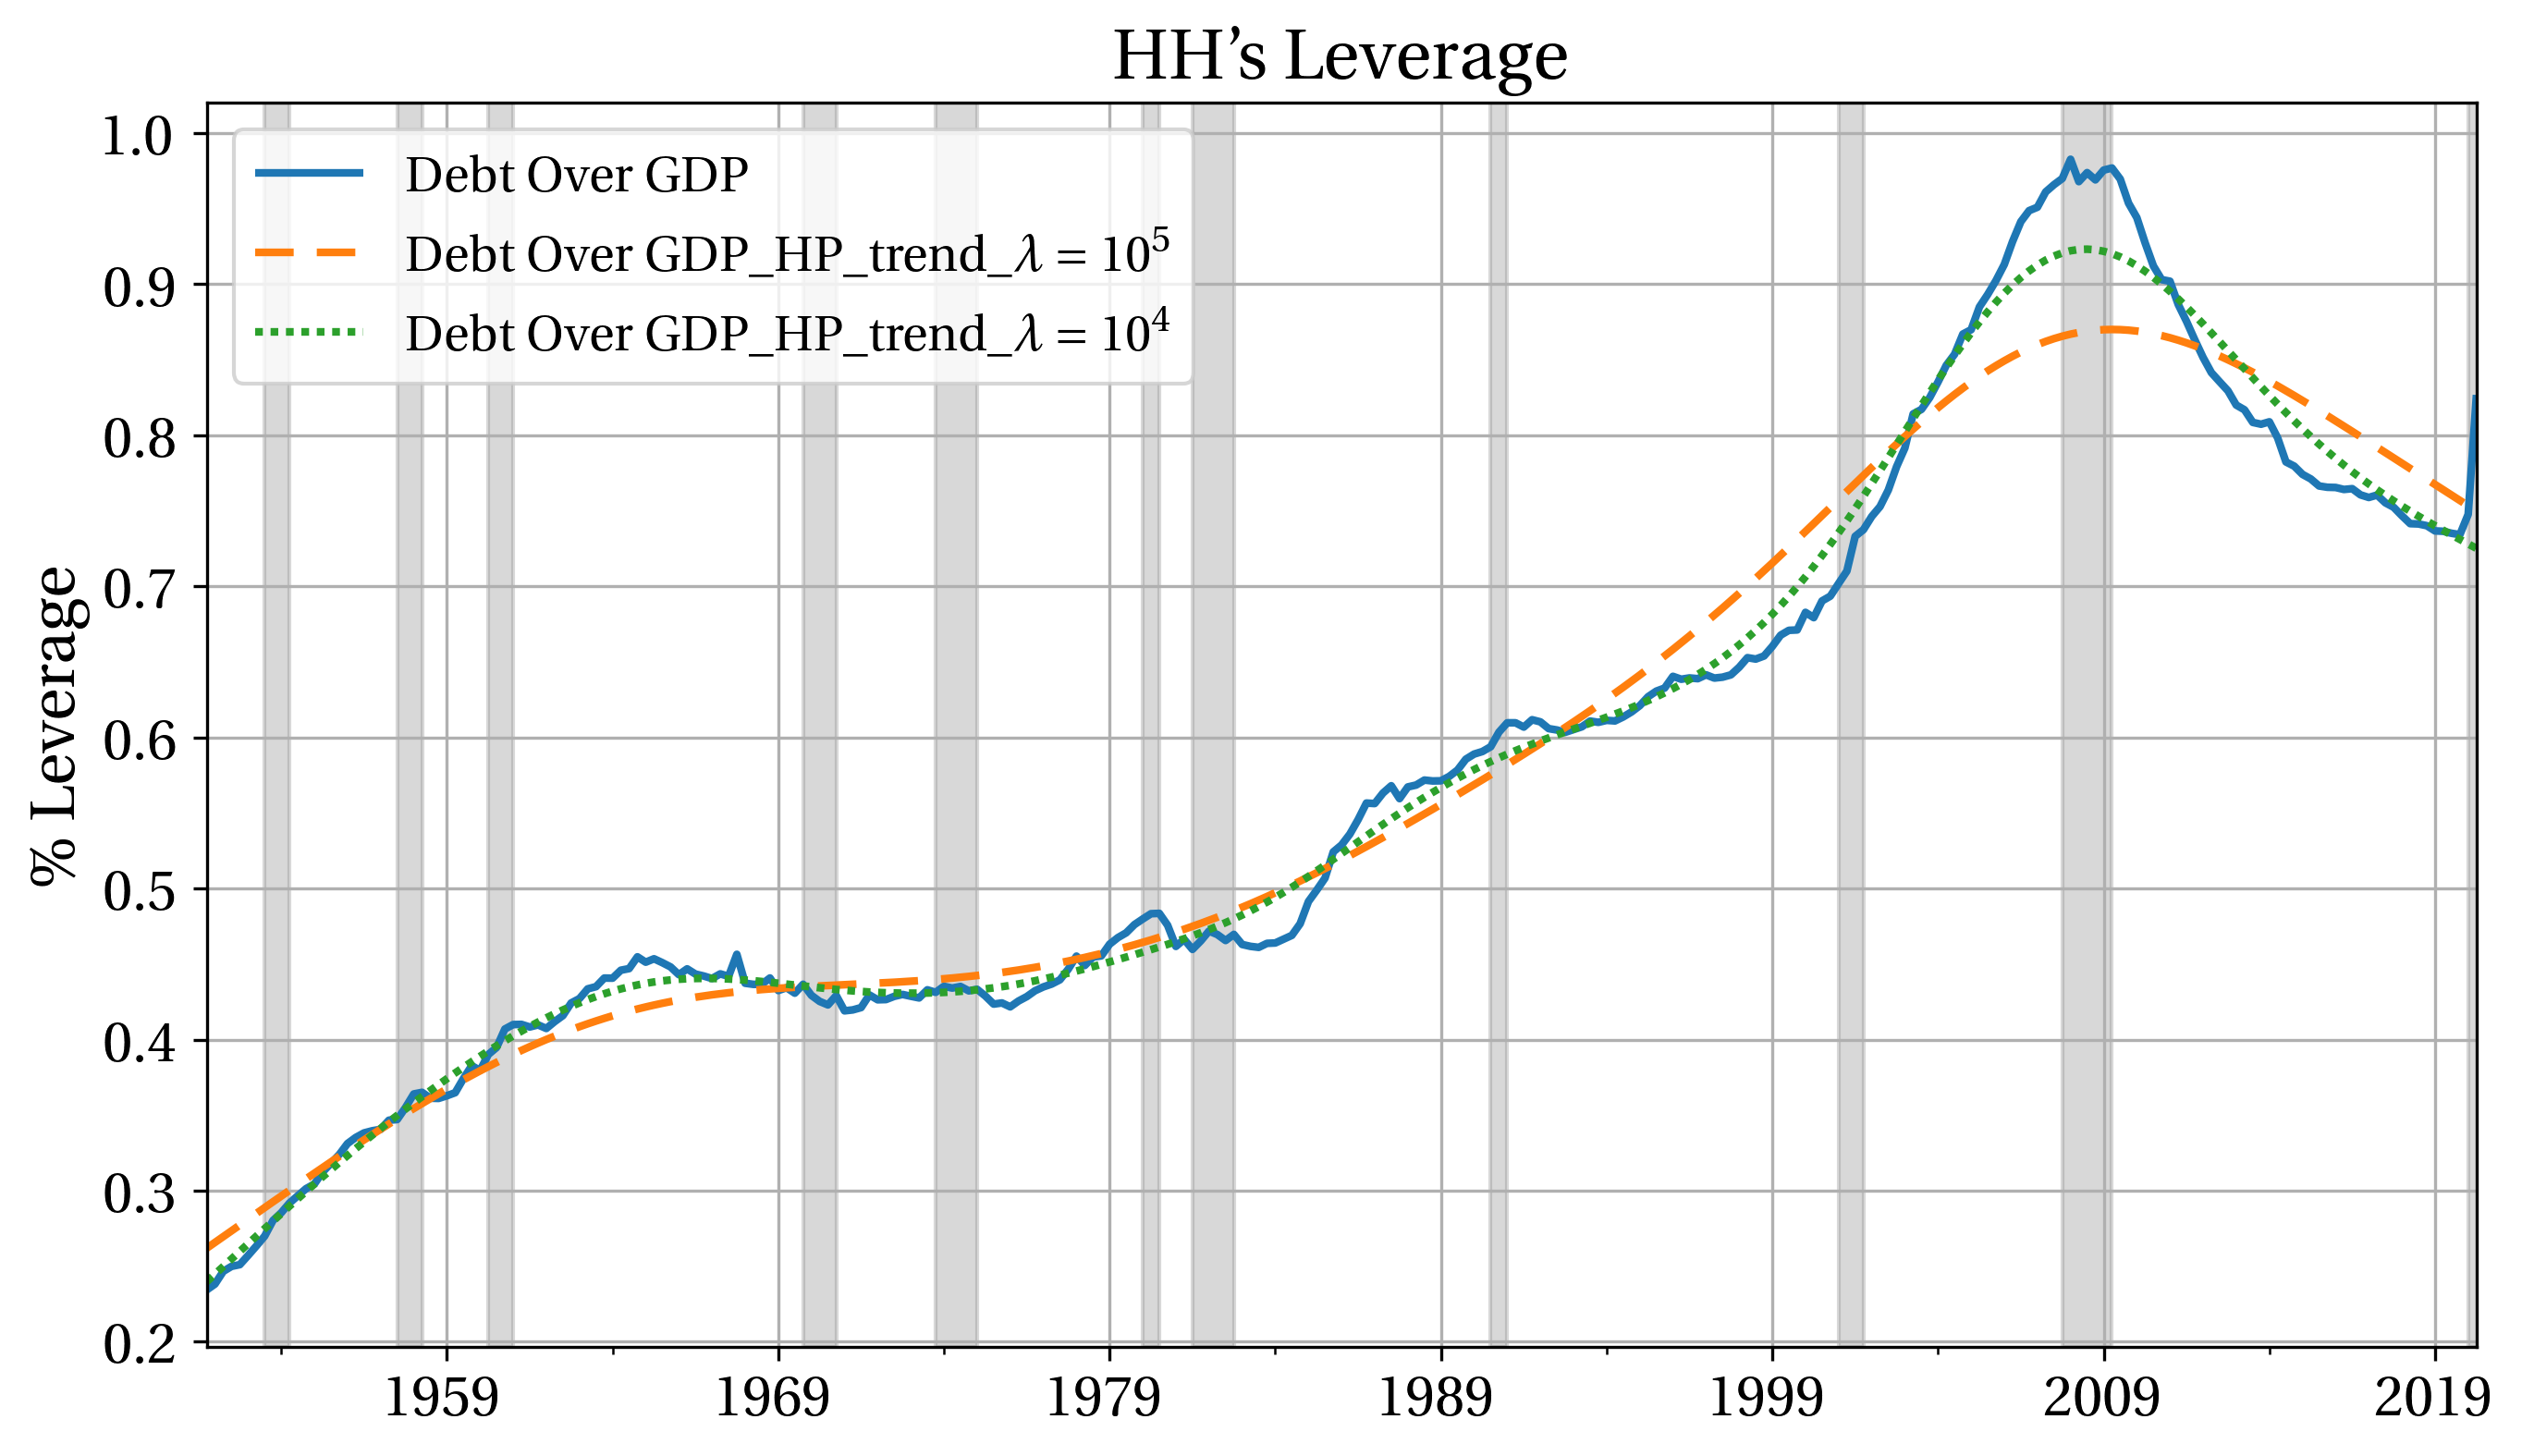

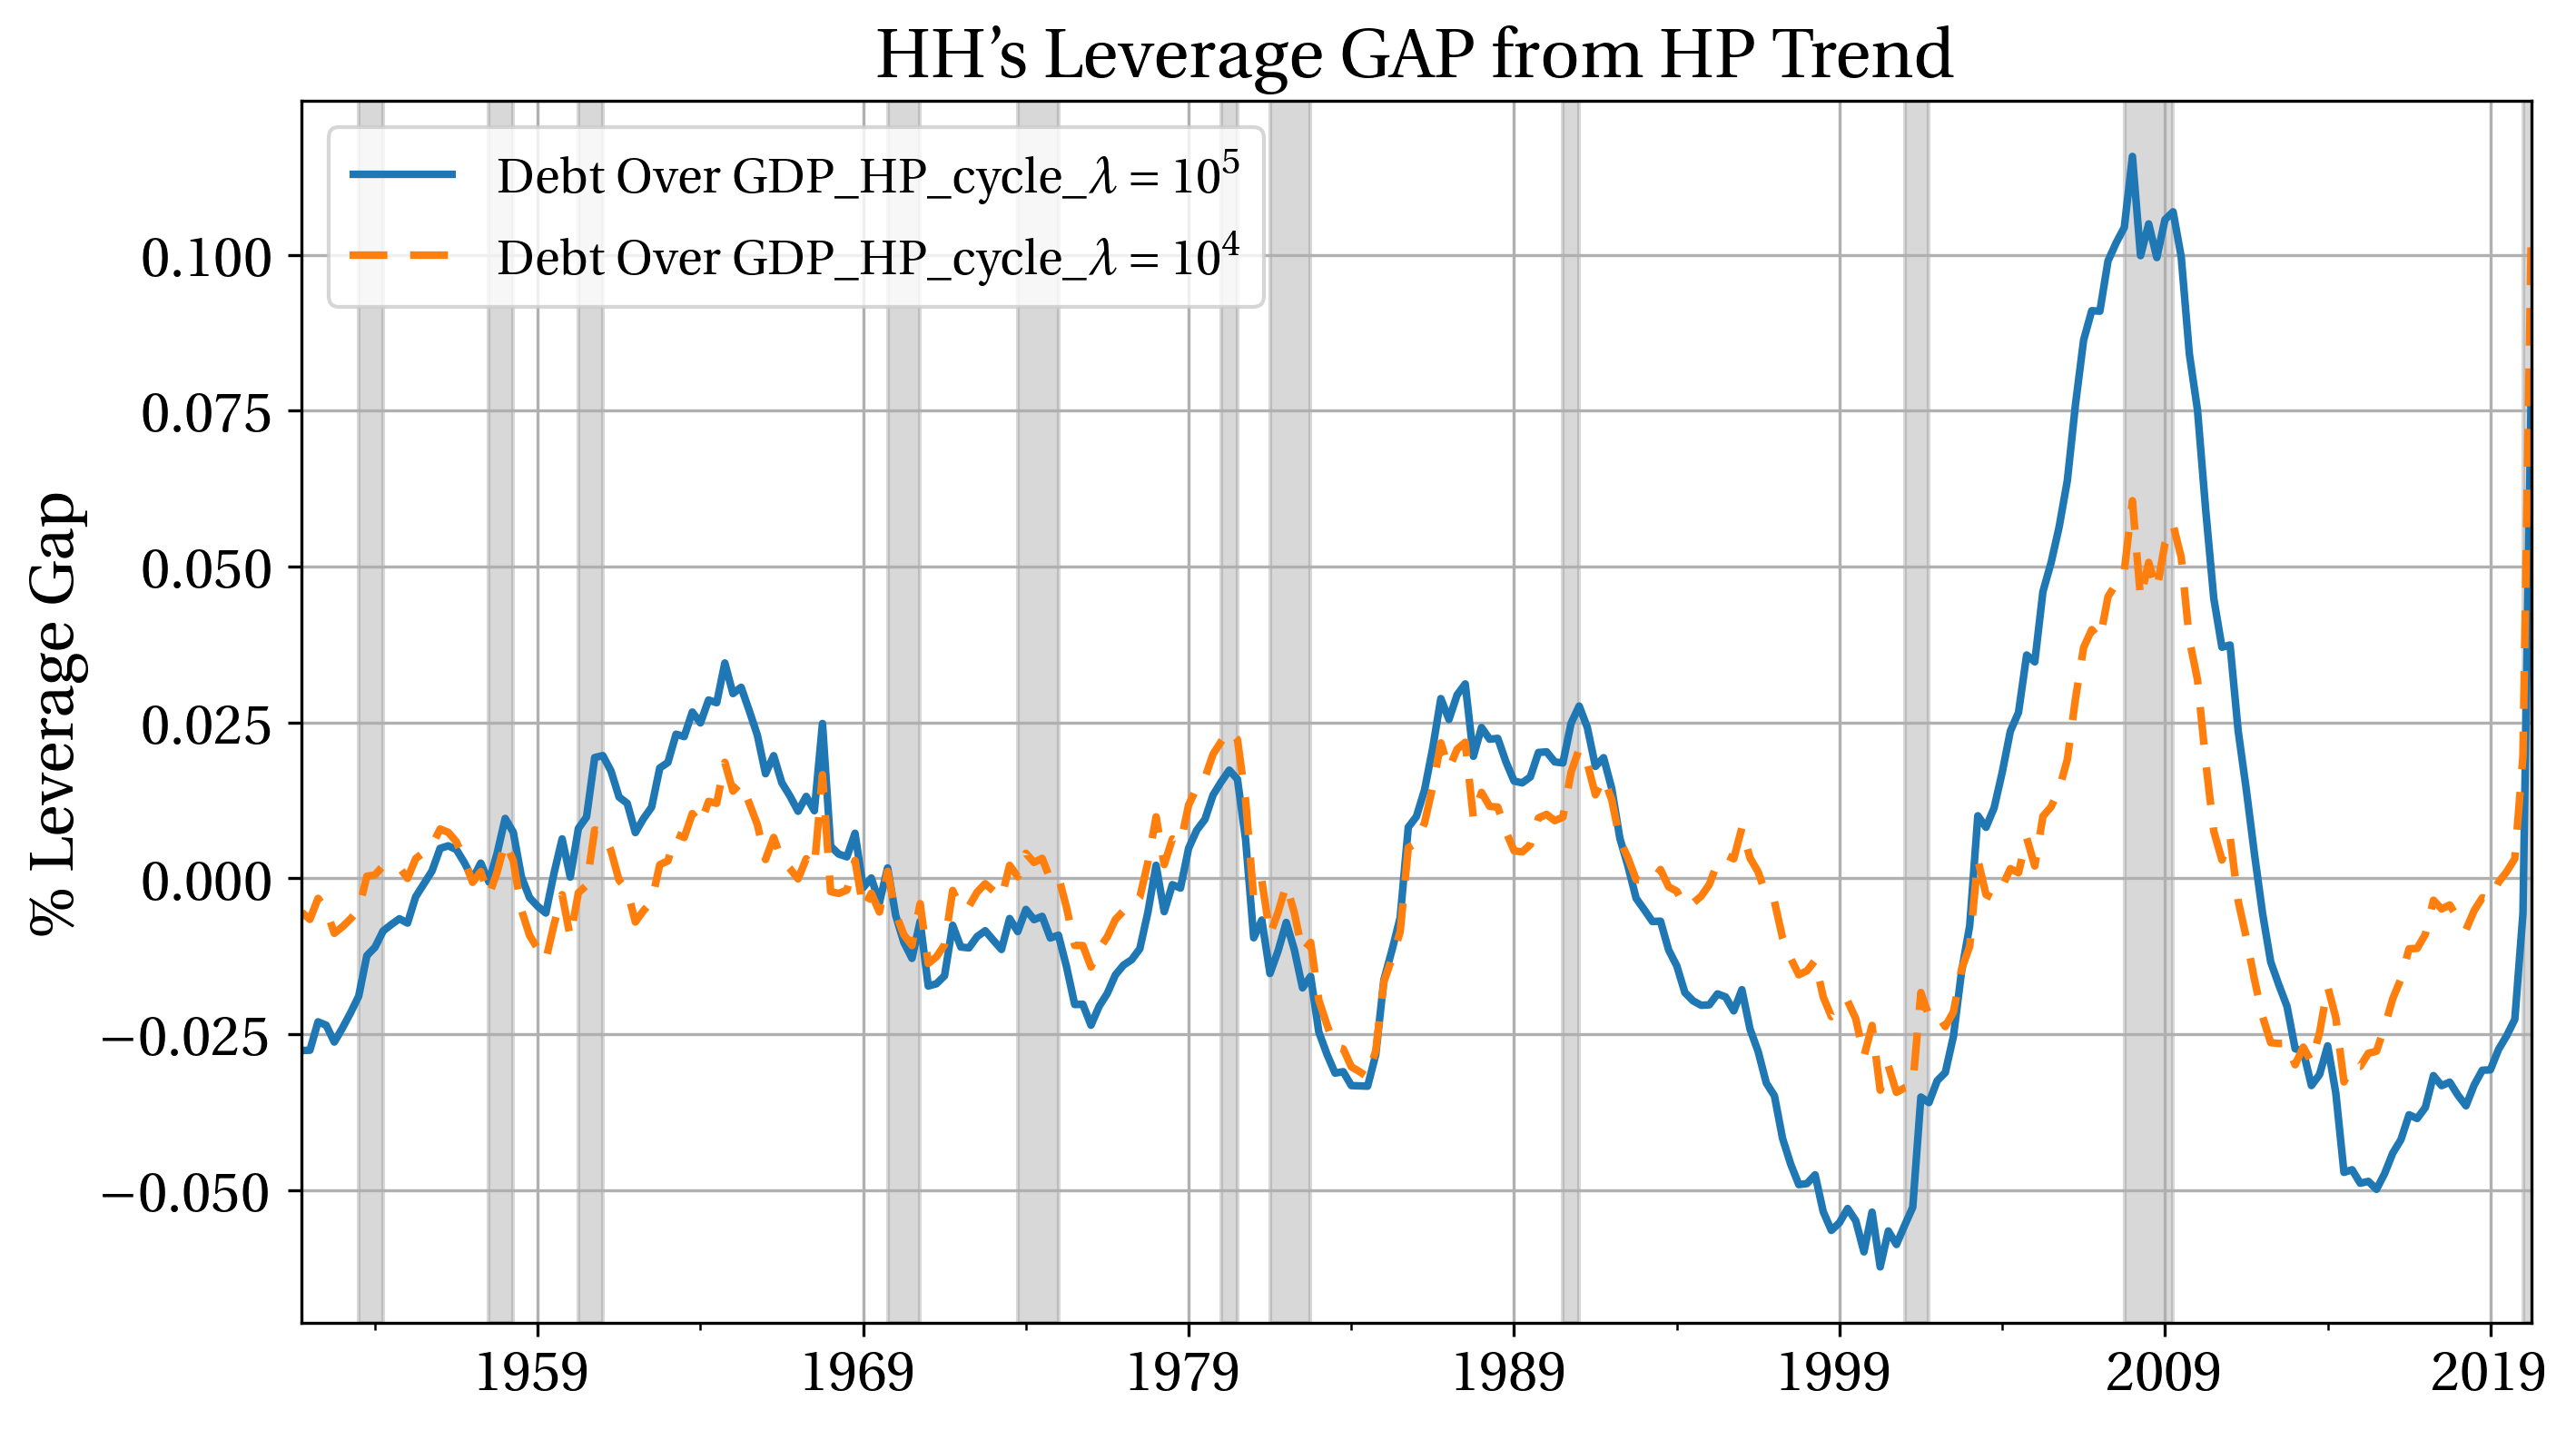

In [26]:
#mask = period(df_US.index,start='1951-01-01',end = '2015-01-01')  # this is to replicate AZ 2019
mask = period(df_US.index,start='1951-01-01')
title='HH\'s Leverage'
lamb_pow = 5
lamb = 10**lamb_pow
lamb_str = '_$\lambda=10^'+str(lamb_pow)+'$'    # '_$\lambda=10^4$'
col = 'Debt Over GDP'
df_US[col+'_HP_cycle'+lamb_str],df_US[col+'_HP_trend'+lamb_str]=sm.tsa.filters.hpfilter(df_US.loc[mask,[col]].dropna(), lamb=lamb) 

lamb_pow = 4
lamb = 10**lamb_pow
lamb_str2 = '_$\lambda=10^'+str(lamb_pow)+'$'    # '_$\lambda=10^4$'
df_US[col+'_HP_cycle'+lamb_str2],df_US[col+'_HP_trend'+lamb_str2]=sm.tsa.filters.hpfilter(df_US.loc[mask,[col]].dropna(), lamb=lamb) 

columns=[col]+[col+'_HP_trend'+lamb_str]+[col+'_HP_trend'+lamb_str2]
ax= plot1ax(columns=columns,ylabel='\% Leverage',df=df_US.loc[mask,columns],markers='',xlabel='',title=title)
ax.grid()
add_Rec(ax,df_US[mask],'USRECM')
plt.show()

title='HH\'s Leverage GAP from HP Trend'
columns=[col+'_HP_cycle'+lamb_str]+[col+'_HP_cycle'+lamb_str2]
ax= plot1ax(columns=columns,ylabel='\% Leverage Gap',df=df_US.loc[mask,columns],markers='',xlabel='',title=title)
ax.grid()
add_Rec(ax,df_US[mask],'USRECM')
plt.show()

### Why is it important to replicate other works?
Alpanda and Zubairy 2019 wrote that they use $\lambda=10^4$ but...they actually use $\lambda=10^5$!
See Fig. 1. from there article below:

In [14]:
#from IPython.display import Image
#Image(filename='AlpandaZubairy2019_Fig1.png')

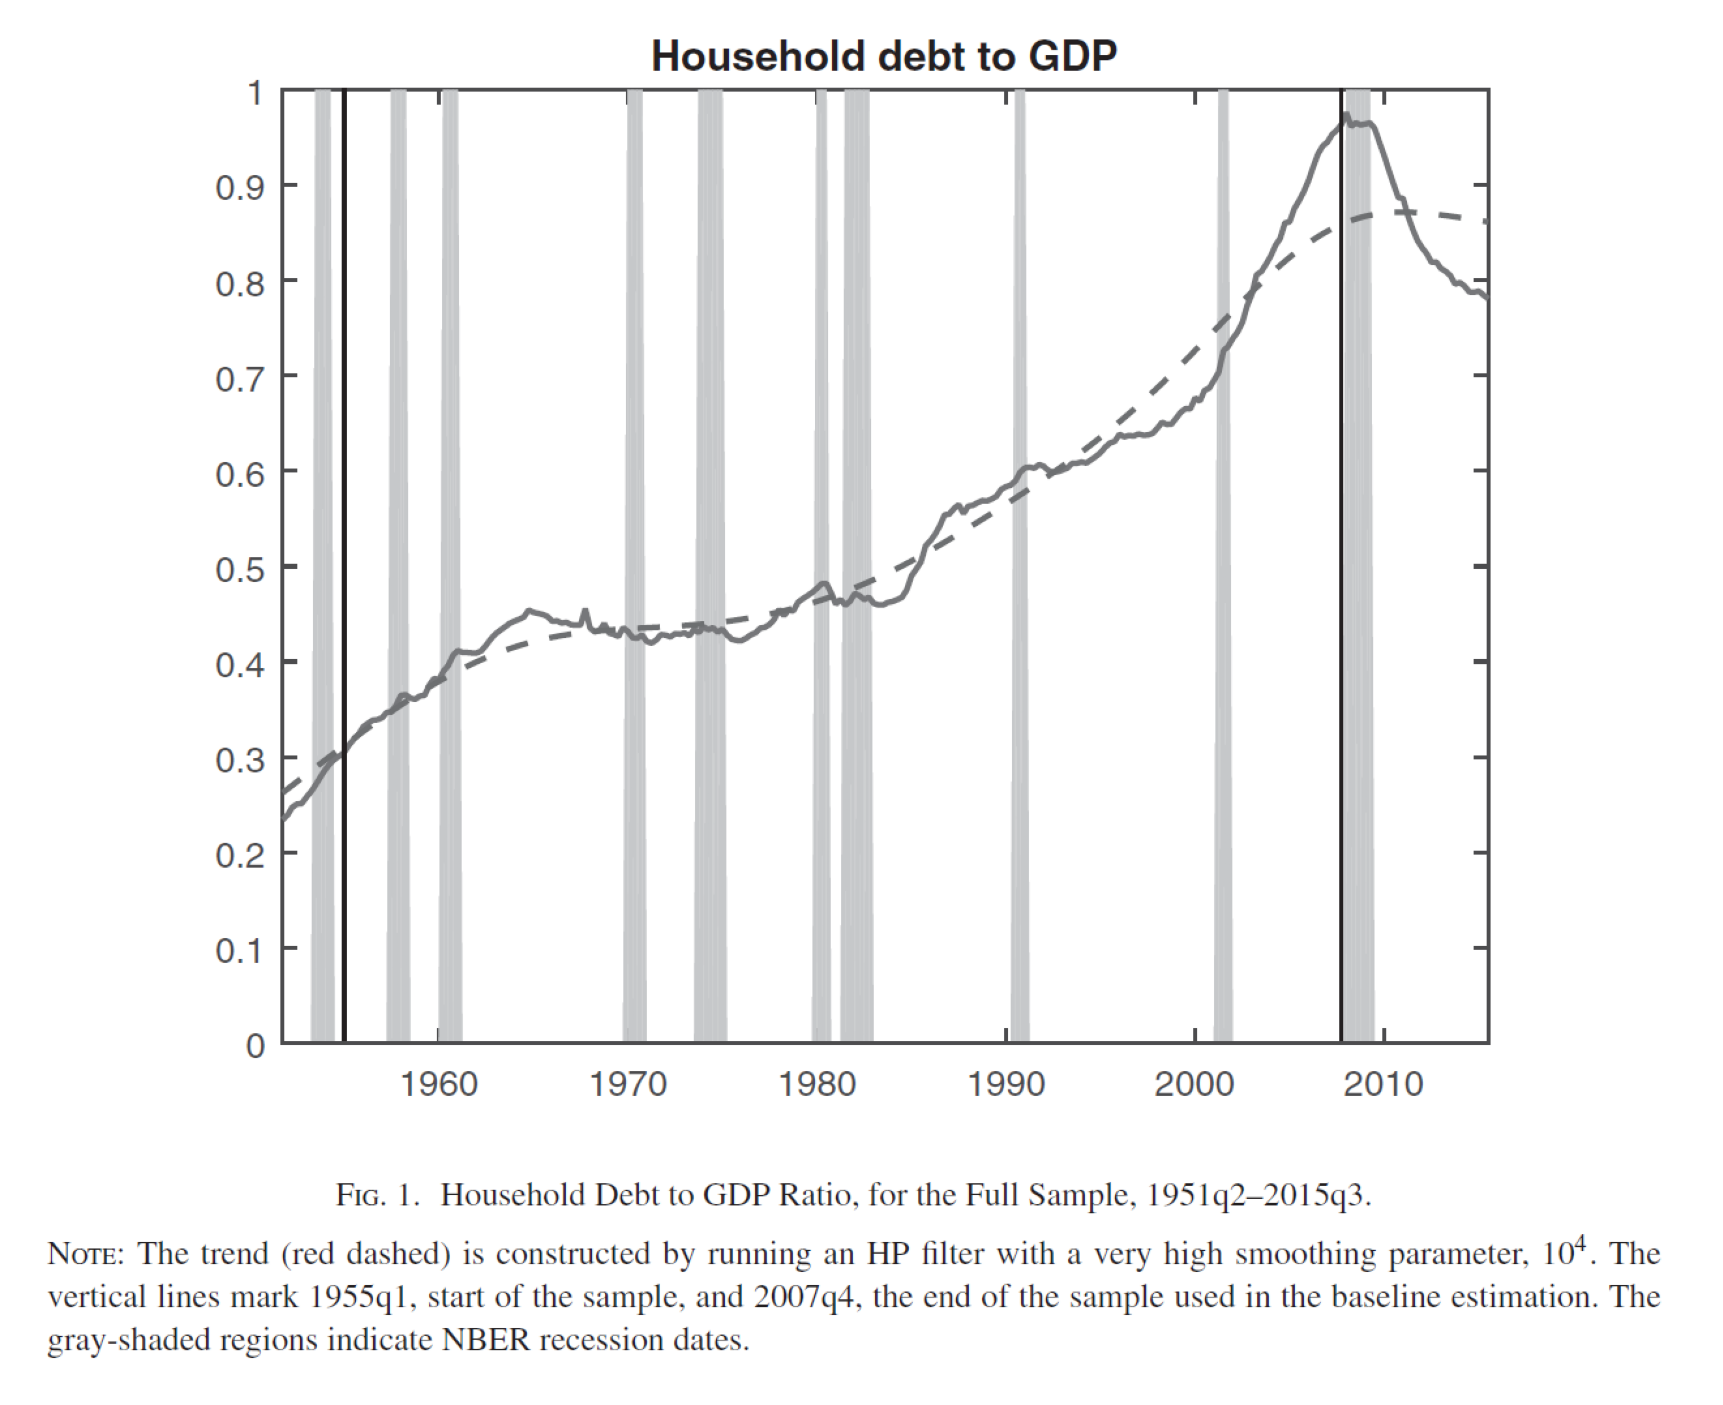

In [27]:
os.chdir(current_NB_path)
import matplotlib.image as mpimg
plt.rcParams['figure.dpi']= 300
image = mpimg.imread("AlpandaZubairy2019_Fig1.png")
plt.imshow(image)
plt.axis('off')
plt.show()
os.chdir(project_path)

## Leverage vs IR

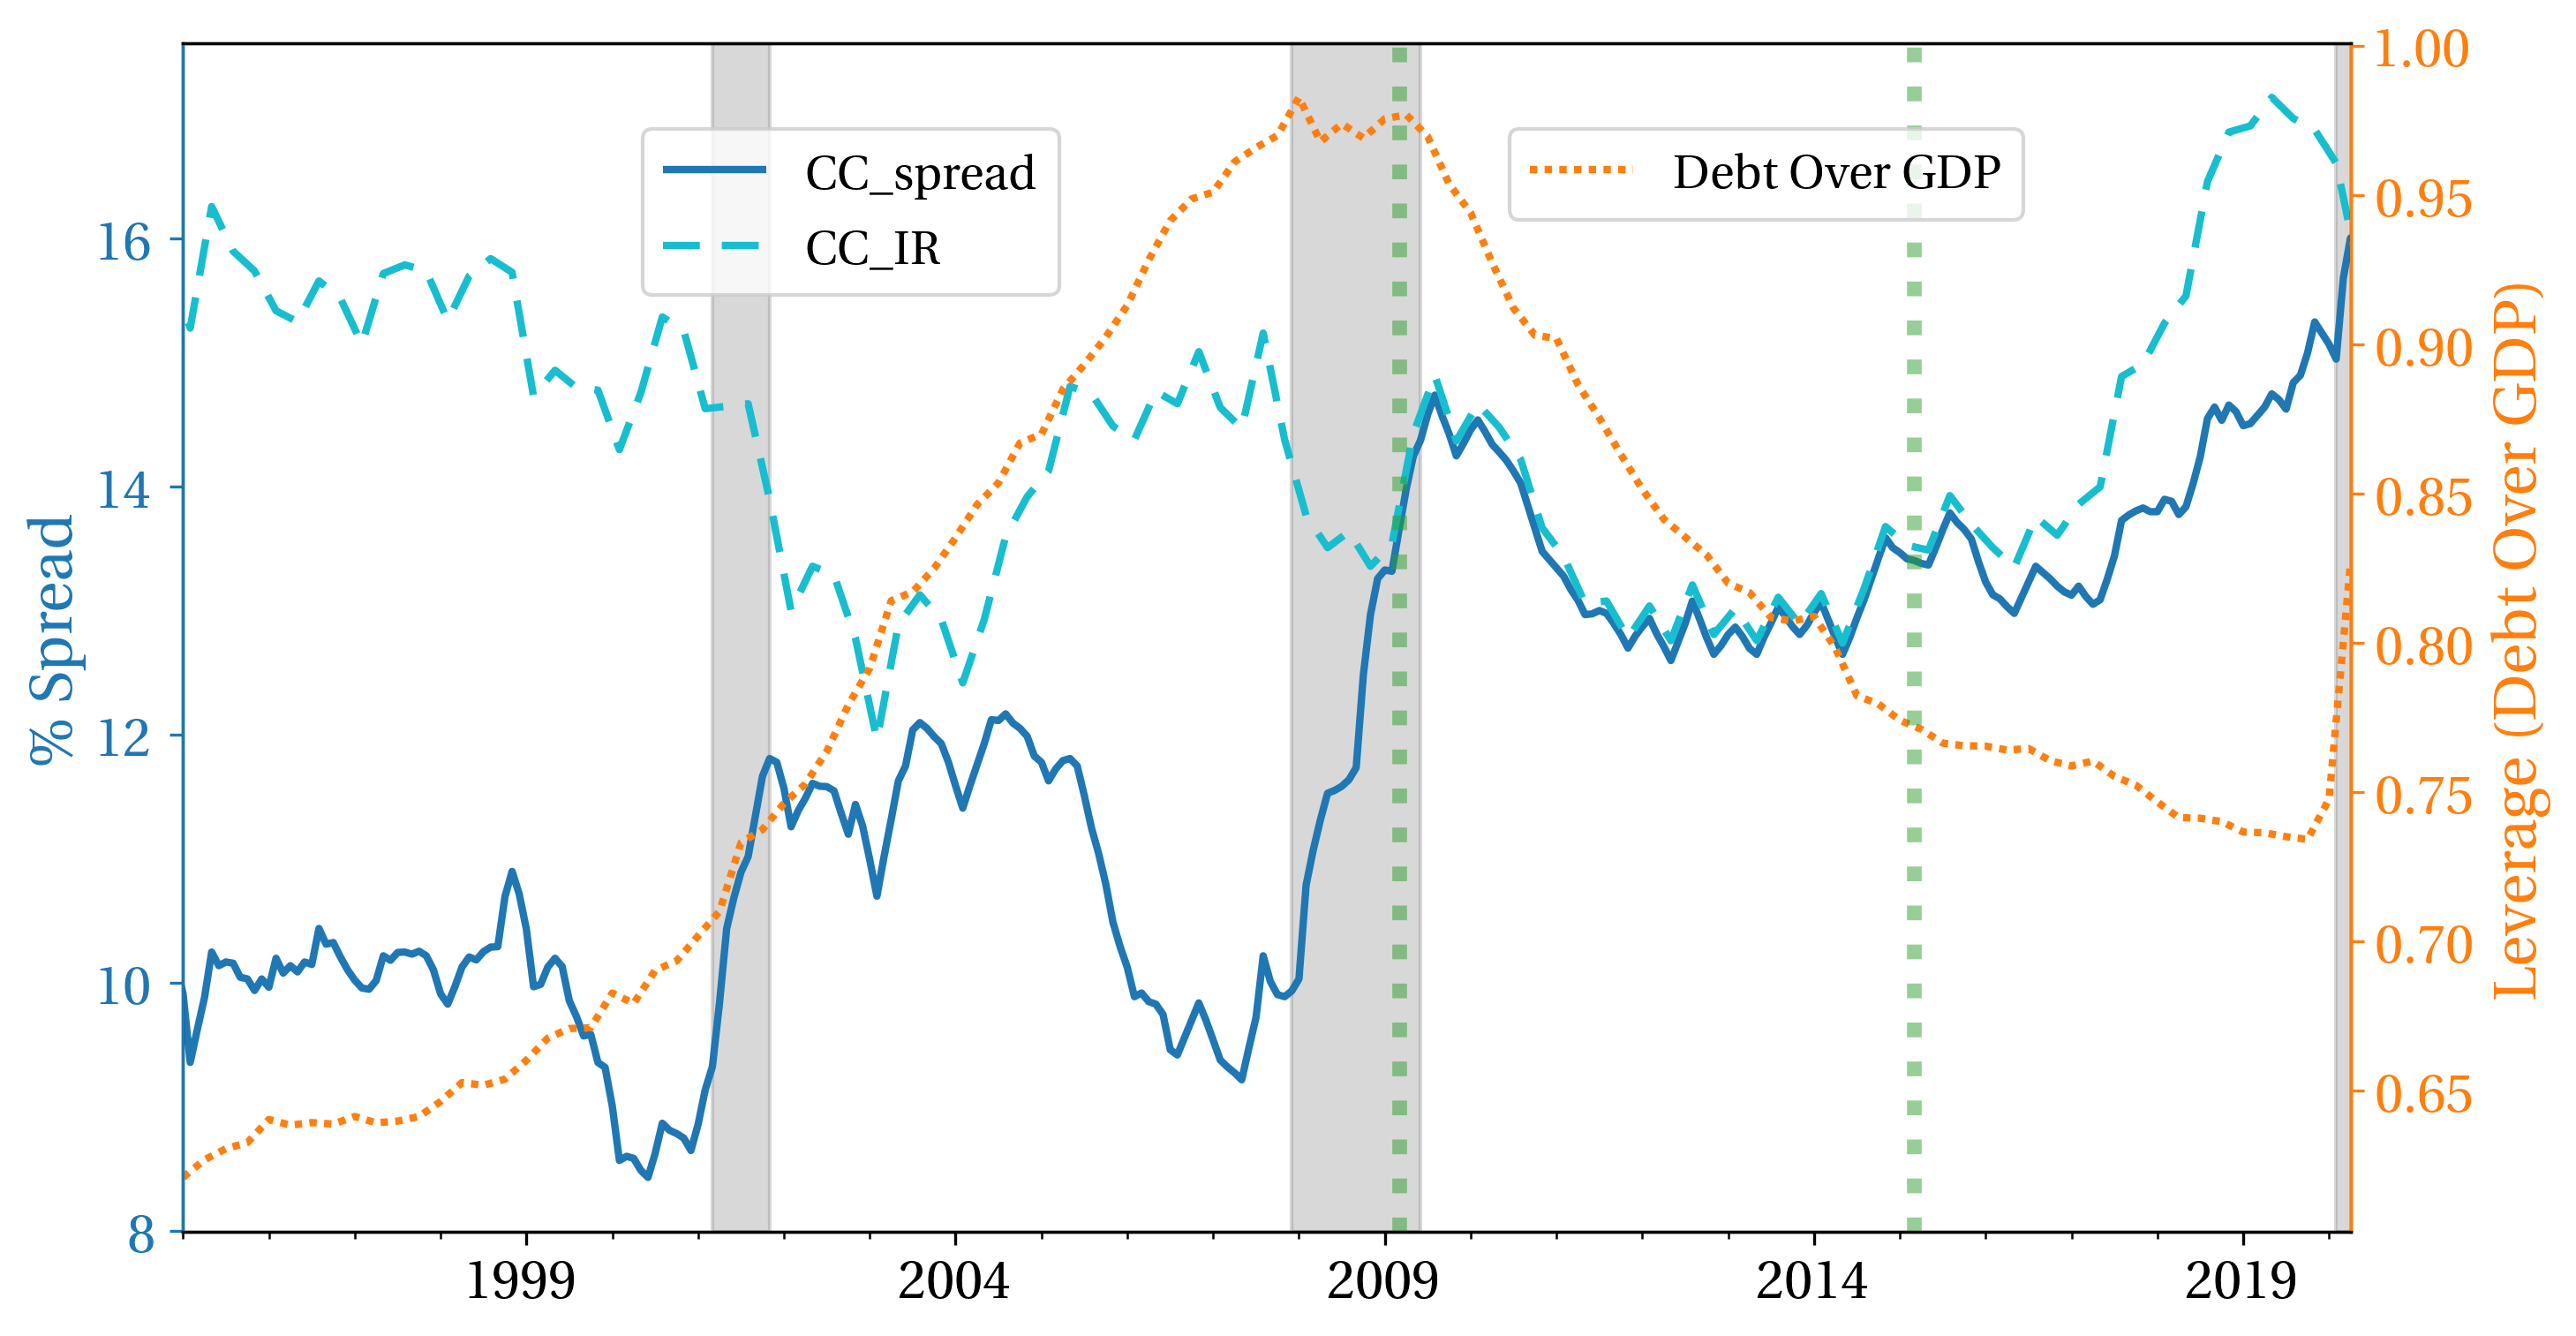

In [33]:
mask = period(df_US.index,start=df_info.at['observation_start','TERMCBCCINTNS'])#start = '2015-02-01'
#with plt.xkcd():
if True:
    col1=['CC_spread','CC_IR']
    col2=['Debt Over GDP']
    ax1,ax2 = plot2axs(columns1=col1,columns2=col2,
                       ylabel1 ='\% Spread' , ylabel2='Leverage (Debt Over GDP)',
                       df=df_US.loc[mask,col1+col2],
                       markers=markers_l,
                       bbox1=(0.2, 0.95),bbox2=(0.6, 0.95))    
    add_Rec(ax1,df_US,'USRECM')
    ax2.axvline(x='2009-03-31' ,linewidth=4, color=colors[2],linestyle=':',alpha=0.5)
    ax2.axvline(x='2015-03-31' ,linewidth=4, color=colors[2],linestyle=':',alpha=0.5)

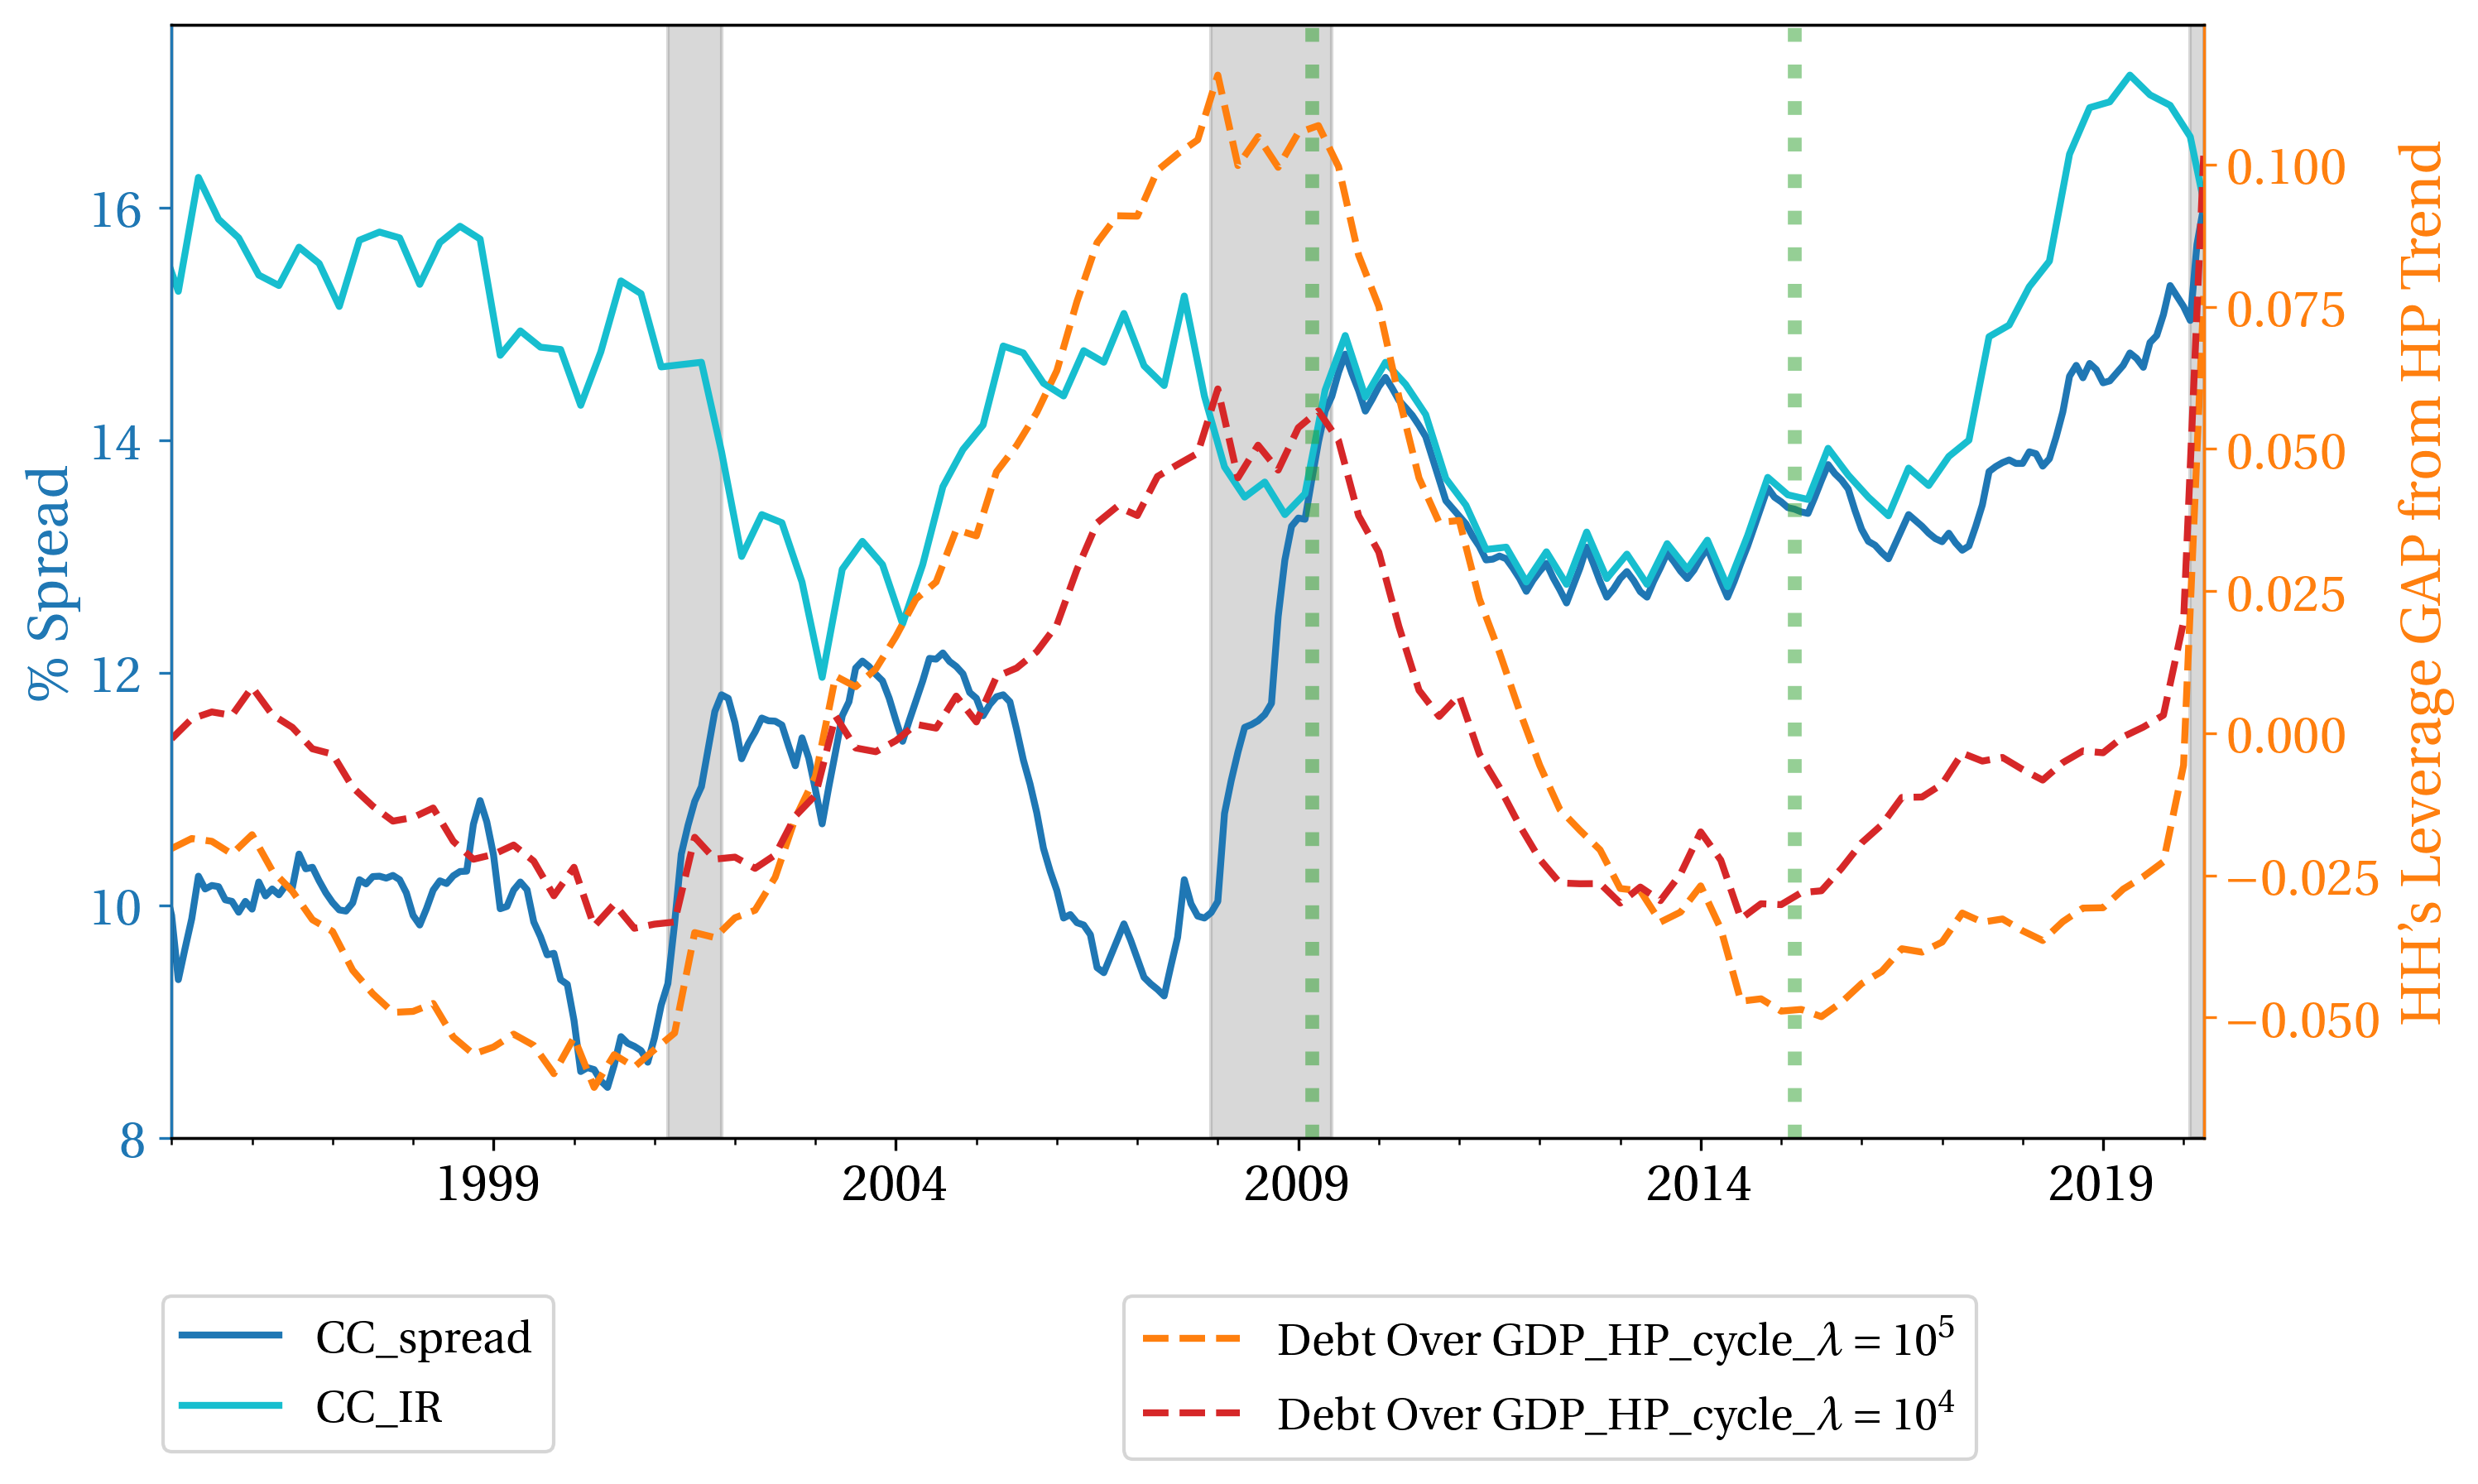

In [29]:
mask = period(df_US.index,start=df_info.at['observation_start','TERMCBCCINTNS'])#start = '2015-02-01'
#with plt.xkcd():
if True:
    col1=['CC_spread','CC_IR']
    col2=[col+'_HP_cycle'+lamb_str]+[col+'_HP_cycle'+lamb_str2]
    ax1,ax2 = plot2axs(columns1=col1,columns2=col2,
                       ylabel1 ='\% Spread' , ylabel2='HH\'s Leverage GAP from HP Trend',
                       df=df_US.loc[mask,col1+col2],
                       markers=markers_l,linestyles=['-','-','--','--'],
                       bbox1=(0.2, -0.12),bbox2=(0.9, -0.12))    
    add_Rec(ax1,df_US,'USRECM')
    ax2.axvline(x='2009-03-31' ,linewidth=4, color=colors[2],linestyle=':',alpha=0.5)
    ax2.axvline(x='2015-03-31' ,linewidth=4, color=colors[2],linestyle=':',alpha=0.5)

In [56]:
%%capture

# Should unmark the seting: "Jupyter: Theme Matplotlib Plots"
# and rerun notebook...
# must Save Notebook before this

stop - also commant this  


os.chdir(current_NB_path)
###################################################
### IMPORTENT : update Notebook file_name below ###
###################################################
## Print Notebook wo code (inputs)
!jupyter nbconvert 1.0-c-US_data_exploreation.ipynb --no-input --no-prompt --to latex

# to try also https://ipypublish.readthedocs.io/en/latest/ : 
# !nbpublish -f latex_ipypublish_all -pdf file_name.ipynb
# also sphinx and jupinx and more....
os.chdir(project_path)